## DLMIR-1 Lab 3

Today we will start working on keras to build a neural network.
Keras is a high level API. It is a wrapper of tensorflow.
It's a good tool for doing quick prototyping. 

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import matplotlib.pylab as plt

import numpy as np


Using TensorFlow backend.


## Read pre-computed melspec features 

Here are a few code to organize the data.
I've pre-extracted mel-spectrogram features from the dataset, and stored as numpy array.
When you take a look at the labels, they are: 0:guitar, 1:flute, 3:trumpet, 4:violin
Let's first get those features.

In [2]:
data = np.load('../mydata/melspec_4_classes_data.npy')
labels = np.load('../mydata/melspec_4_classes_labels.npy')

# shuffle data and split for training / test
rnd = np.random.permutation(labels.shape[0])
num_train = int(labels.shape[0] * 9/10)
num_val = labels.shape[0] - num_train
print(len(rnd), num_train, num_val)

train_idx = rnd[:num_train]
val_idx = rnd[num_train:]

data_tr  = data[train_idx,:,:]
label_tr = labels[train_idx,]
data_val  = data[val_idx,:,:]
label_val = labels[val_idx,]

# convert the data to the right type
data_tr = data_tr.astype(np.float32)
label_tr = label_tr.astype(np.int32)
data_val = data_val.astype(np.float32)
label_val = label_val.astype(np.int32)

2368 2131 237


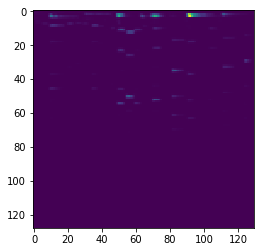

In [3]:
# Let's take a look at the input
x = data_tr[8,:,:]
x = x.reshape(x.shape[0], x.shape[1])
plt.imshow(x)

## Prepare data for training

In [4]:
# The feature that's stored in the numpy array file is mel-spectrogram
# Each having 128 frequency bins, and 130 frames
feature_rows = 128
feature_cols = 130
num_class = 4

data_tr = data_tr.reshape(data_tr.shape[0], feature_rows, feature_cols, 1)
data_val = data_val.reshape(data_val.shape[0], feature_rows, feature_cols, 1)

input_shape = (feature_rows, feature_cols, 1)

# convert class vector to one-hot
label_tr = keras.utils.to_categorical(label_tr, num_class)
label_val = keras.utils.to_categorical(label_val, num_class)

label_tr.shape, label_val.shape

((2131, 4), (237, 4))

Now let's build a basic CNN in Keras, a high-level wrapper for tensorflow. It is easy to use for quick prototyping.
We use a sequential model here, which is a linear stack of model. It is easy to use

## Describe the model

In [5]:
# describe your model here
model = Sequential()

# 2-d convolutional layer
model.add(Conv2D(32, kernel_size=(16, 16), activation='relu', input_shape=input_shape))

# max pooling
model.add(MaxPooling2D(pool_size=(16, 16), strides=(16, 16)))

# The final layer is a dense layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

# Finish designing the model, let's compile it
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Take a look at what's inside the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 115, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               803328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 813,604
Trainable params: 813,604
Non-trainable params: 0
_________________________________________________________________


# Start training! 

In [6]:
class accuracy_callback_fn(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

accuracy_callback = accuracy_callback_fn()

# start the training
batch_size = 128
epochs = 25
model.fit(data_tr, label_tr,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (data_val, label_val),
          callbacks = [accuracy_callback])

Train on 2131 samples, validate on 237 samples
Epoch 1/25
2131/2131 [==============================] - 29s 13ms/step - loss: 7.1495 - acc: 0.3956 - val_loss: 6.4255 - val_acc: 0.4726
Epoch 2/25
2131/2131 [==============================] - 1s 610us/step - loss: 5.2411 - acc: 0.4608 - val_loss: 4.7271 - val_acc: 0.3713
Epoch 3/25
2131/2131 [==============================] - 1s 604us/step - loss: 2.1426 - acc: 0.4214 - val_loss: 1.3793 - val_acc: 0.4177
Epoch 4/25
2131/2131 [==============================] - 1s 601us/step - loss: 1.3032 - acc: 0.4857 - val_loss: 1.2649 - val_acc: 0.5190
Epoch 5/25
2131/2131 [==============================] - 1s 602us/step - loss: 1.1146 - acc: 0.5800 - val_loss: 1.2169 - val_acc: 0.5612
Epoch 6/25
2131/2131 [==============================] - 1s 606us/step - loss: 1.0021 - acc: 0.6190 - val_loss: 1.1992 - val_acc: 0.5823
Epoch 7/25
2131/2131 [==============================] - 1s 604us/step - loss: 0.8907 - acc: 0.6645 - val_loss: 1.2984 - val_acc: 0.5696
E

## Evaluate

Validation loss: 2.1569959523808606
Validation accuracy: 0.607594936834609


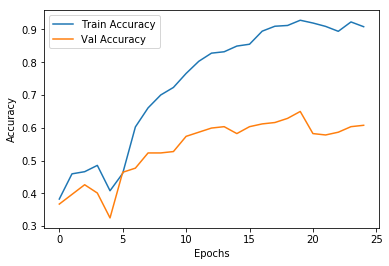

In [8]:
score = model.evaluate(data_val, label_val, verbose=0)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
tr_acc, = plt.plot(range(epochs), accuracy_callback.acc)
val_acc, = plt.plot(range(epochs), accuracy_callback.val_acc)
plt.legend([tr_acc, val_acc], ['Train Accuracy', 'Val Accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Now it's your turn. Can you make it better?